<a href="https://colab.research.google.com/github/kyle-gao/ML_ipynb/blob/master/TF_GradientTape_MatMulTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I'm implementing a hand-made naive matrix multplication compatible with tf.Gradient.Tape.


The intention is to benchmark speed for future custom linalg operations (such as the diagonal attention mechanism from Longformer).

In [1]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [2]:
A=tf.Variable(tf.random.normal((2,3)))
B=tf.Variable(tf.random.normal((3,2)))

We use tf.TensorArray when we have computation in a loop since we can't assign values to eager tensors in normal circumstances.


We need to have the functions return TensorArray.stack()

#Example: Naive Matrix multiplication

In [34]:
#We note that tf.TensorArray() creates one dimensional arrays
#For computations requiring nested loops, we need to nest TensorArray

def get_col(A,B,col):
  (m,k)=tf.shape(A)
  (k,n)=tf.shape(B)
  C_col=tf.TensorArray(A.dtype, size=n)
  for i in range(n): #inner loop must be rows since want list of rows
    sum=0.0
    for l in range(k):
      sum=sum+A[col,l]*B[l,i]
    C_col=C_col.write(i,sum) #TensorArray.write() to assign values
  return C_col.stack() #must return .stack() which returns a tensor, since we can't make a TensorArray of TensorArray, .concat() is also an option but buggier.

def matrix_multiply(A,B):
  (m,k)=tf.shape(A)
  (k,n)=tf.shape(B)
  C=tf.TensorArray(A.dtype, size=m,element_shape=(n,))
  for col in range(m): #outer loop is columns since we want list of rows.
    C=C.write(col,get_col(A,B,col))
  return C.stack() 

#test
A=tf.Variable(tf.random.normal((2,3)))
B=tf.Variable(tf.random.normal((3,4)))
matrix_multiply(A,B)-tf.matmul(A,B)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [4]:
with tf.GradientTape() as tape:
    M=matrix_multiply(A,B) #make sure the arguments are tf.Variable
    norm=tf.norm(M)
print(tape.gradient(norm,(A,B)))

(<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-0.06420016, -3.1879365 , -0.52598125],
       [ 0.23336388,  0.63821113,  0.12002391]], dtype=float32)>, <tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-0.25122416,  0.57766974,  0.30479246,  0.10148753],
       [-0.39062908,  1.1474692 ,  0.25855574,  0.03113993],
       [ 0.1977827 , -0.74560505,  0.01133072,  0.06788995]],
      dtype=float32)>)


#Test
how slow is a naive implementation?

In [14]:
def time_matmul(n, mul):
  A = tf.Variable(tf.random.normal((n,n)))
  B = tf.Variable(tf.random.normal((n,n)))
  start = time.time()
  out = mul(A,B)
  end = time.time()
  return end-start

In [17]:
sizes = range(5,25,5)

In [18]:
naive_times=[]
tf_times=[]
for size in sizes:
  naive_times.append(time_matmul(size,matrix_multiply))
  tf_times.append(time_matmul(size,tf.matmul))

In [16]:
time_matmul(30, matrix_multiply)

6.502772092819214

Text(0.5, 1.0, 'Matrix Multiplication benchmark on CPU')

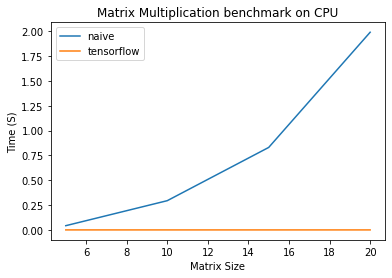

In [33]:
plt1=plt.plot(sizes,naive_times,label='naive')
plt2=plt.plot(sizes,tf_times,label='tensorflow')
plt.legend(loc="upper left")
plt.xlabel("Matrix Size");
plt.ylabel("Time (S)");
plt.title("Matrix Multiplication benchmark on CPU");

It looks like custom linalg functions should be implemented in c++ CUDA as ops https://www.tensorflow.org/guide/create_op.
Unfortunately, back prop gradients must be handcoded.

Even on the CPU the naive implementation horribly underperforms, let alone the GPU where tf.matmul is optimized for.